<b>Import libraries

In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import (RFE, SelectFromModel, SelectKBest,
                                       SequentialFeatureSelector,
                                       VarianceThreshold, chi2, f_classif,
                                       mutual_info_classif)
from sklearn.metrics import (auc, classification_report, confusion_matrix,
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from diagnostics import ClassificationDiagnostics  # custom class
from minmaxscaler import mmscaler  # custom function


<b>Import dataset


In [2]:
DATA_PATH = os.path.join(Path(os.getcwd()).parent, "data\\train_set.pkl")

In [5]:
with open(DATA_PATH,"rb") as f:
    df = pickle.load(f)
df

,Date,Index,daily_returns,momentum30,momentum60,momentum120,vs_quantile,vs_quantile_binary,vs_quantile_binary_freq,divergence,lag_returns,sell_signal
0,2010-06-25,4.579647,0.545185,98.852998,99.186729,99.445776,0.148886,0.0,0.083333,-0.030905,-2.193406,1
1,2010-06-28,4.580263,0.061532,99.368701,99.155543,99.465618,0.141364,0.0,0.083333,-0.031225,0.545185,1
2,2010-06-29,4.537961,-4.230111,98.279685,97.914172,98.598467,-1.823472,1.0,0.100000,-0.032261,0.061532,1
3,2010-06-30,4.523635,-1.432674,98.375237,97.596871,98.342961,-0.228739,0.0,0.100000,-0.032895,-4.230111,1
4,2010-07-01,4.522223,-0.141143,98.439591,97.601193,98.128629,0.136183,0.0,0.100000,-0.033432,-1.432674,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2896,2021-12-27,7.338830,2.007130,100.490500,101.924288,101.959527,0.445107,0.0,0.033333,0.025429,0.781389,0
2897,2021-12-28,7.334336,-0.449377,100.309045,101.708571,102.030084,0.113669,0.0,0.033333,0.024129,2.007130,0
2898,2021-12-29,7.337347,0.301111,100.382438,102.028622,101.880797,0.137352,0.0,0.033333,0.022629,-0.449377,0
2899,2021-12-30,7.330857,-0.648971,100.167129,101.782684,101.794794,0.093081,0.0,0.033333,0.020897,0.301111,0


<b> Minmax scaler

In [6]:
num_columns = ["daily_returns", "momentum30", "momentum60", "momentum120", "vs_quantile", "divergence", "lag_returns"]
df = mmscaler(df = df, columns = num_columns)
df

,daily_returns,momentum30,momentum60,momentum120,vs_quantile,divergence,lag_returns,Date,Index,vs_quantile_binary,vs_quantile_binary_freq,sell_signal
0,0.584934,0.441176,0.404351,0.350211,0.588236,0.393218,0.474406,2010-06-25,4.579647,False,0.083333,True
1,0.565414,0.492704,0.40173,0.351646,0.587818,0.391574,0.584934,2010-06-28,4.580263,False,0.083333,True
2,0.392206,0.383893,0.297372,0.288934,0.478561,0.386246,0.565414,2010-06-29,4.537961,True,0.1,True
3,0.505109,0.39344,0.270697,0.270457,0.567238,0.382988,0.392206,2010-06-30,4.523635,False,0.1,True
4,0.557234,0.39987,0.271061,0.254956,0.58753,0.380228,0.505109,2010-07-01,4.522223,False,0.1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2896,0.643938,0.60479,0.634489,0.532002,0.604708,0.682735,0.594467,2021-12-27,7.33883,False,0.033333,False
2897,0.544794,0.586659,0.616354,0.537105,0.586278,0.676053,0.643938,2021-12-28,7.334336,False,0.033333,False
2898,0.575083,0.593992,0.64326,0.526309,0.587595,0.668345,0.544794,2021-12-29,7.337347,False,0.033333,False
2899,0.536739,0.572479,0.622585,0.520089,0.585133,0.659443,0.575083,2021-12-30,7.330857,False,0.033333,False


<b> Specify model and set up cross validator

In [7]:
# QuadraticDiscriminantAnalysis

model = QuadraticDiscriminantAnalysis()

In [9]:
# Specify dependent variable and predictors

y = df.loc[:,"sell_signal"]
X = df.loc[:, df.columns.drop(["Date","Index","sell_signal"])]

In [10]:
# Cross Validator

cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=123)

# Generate train and test sets using stratified K-fold splits, decide if number of positive classes in train/test splits is sufficient

for train_idx, test_idx in cv.split(X,y):
    # print(train_idx)
    train_X, test_X = X.loc[train_idx, :], X.loc[test_idx,:]
    train_y, test_y = y[train_idx], y[test_idx]

    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])

    print(">Train: 0=%d, 1=%d, Test: 0=%d, 1=%d" % (train_0, train_1, test_0, test_1))

>Train: 0=2231, 1=379, Test: 0=248, 1=43
>Train: 0=2232, 1=379, Test: 0=247, 1=43
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42


In [11]:
# Stratified K-Fold cross validation using F1 stat as model evaluation metric - focus on minority class
# Fit using all features

scores = cross_val_score(model, X, y, scoring = "f1", cv = cv, n_jobs = -1)
print("F1 score: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

F1 score: 0.536 (0.066)


<b> Feature Selection</b>  
Can model perform better on limited number of features?

In [12]:
# Create dictionary to store selected features

feature_selection = {}
feature_selection["Features_set"] = X.columns.tolist()

<font size = 3><u> 1. Variance treshold optimization

In [13]:
# Parameters optimization

pipe = Pipeline(
    [("selector", VarianceThreshold()),("classifier",model)]
)

parameters = {
    "selector__threshold": [0.001, 0.0025, 0.005, 0.007, 0.01, 0.02, 0.03]   
}

grid = GridSearchCV(pipe, parameters, cv = cv, scoring = "f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)
pd.DataFrame.from_dict(grid.cv_results_, orient = "columns")

{'selector__threshold': 0.005}
Pipeline(steps=[('selector', VarianceThreshold(threshold=0.005)),
                ('classifier', QuadraticDiscriminantAnalysis())])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__threshold,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016116,0.002899,0.007002,0.001612,0.001,{'selector__threshold': 0.001},0.623377,0.623377,0.605263,0.605263,0.685714,0.526316,0.641975,0.666667,0.527778,0.571429,0.607716,0.050565,4
1,0.019560,0.003309,0.007610,0.001361,0.0025,{'selector__threshold': 0.0025},0.623377,0.623377,0.605263,0.605263,0.685714,0.526316,0.641975,0.666667,0.527778,0.571429,0.607716,0.050565,4
2,0.015863,0.002035,0.006837,0.001207,0.005,{'selector__threshold': 0.005},0.615385,0.640000,0.658228,0.613333,0.676056,0.609756,0.658228,0.692308,0.472222,0.597015,0.623253,0.058417,1
3,0.010897,0.001446,0.005601,0.000663,0.007,{'selector__threshold': 0.007},0.600000,0.615385,0.641975,0.600000,0.702703,0.602410,0.641975,0.683544,0.459459,0.608696,0.615615,0.062196,2
4,0.010701,0.001187,0.005000,0.001343,0.01,{'selector__threshold': 0.01},0.600000,0.615385,0.641975,0.600000,0.702703,0.602410,0.641975,0.683544,0.459459,0.608696,0.615615,0.062196,2
5,0.009500,0.000924,0.004500,0.000673,0.02,{'selector__threshold': 0.02},0.406250,0.451613,0.447761,0.354839,0.421053,0.347826,0.424242,0.372881,0.196721,0.285714,0.370890,0.075777,6
6,0.009299,0.001099,0.004701,0.001101,0.03,{'selector__threshold': 0.03},0.310345,0.222222,0.290909,0.218182,0.208333,0.262295,0.290909,0.290909,0.148148,0.163265,0.240552,0.054164,7


In [14]:
# Variance Threshold with optimized selector__threshold 0.005

pipe = Pipeline(
    [("selector", VarianceThreshold(threshold=0.005)), ("classifier", model)]
)

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["VarianceThreshold"] = features.tolist()

<font size = 3><u> 2. KBest univariate feature selection (chi2 test) optimization

In [15]:
# Parameters optimization

pipe = Pipeline([
    ("selector", SelectKBest(chi2)), ("classifier",model)
])

parameters = {"selector__k": range(1, X.shape[1])}

grid = GridSearchCV(pipe, parameters, cv=cv, scoring="f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)

{'selector__k': 6}
Pipeline(steps=[('selector',
                 SelectKBest(k=6,
                             score_func=<function chi2 at 0x000002BA917F45E0>)),
                ('classifier', QuadraticDiscriminantAnalysis())])


Text(0.5, 1.0, 'F1 score @ number of features')

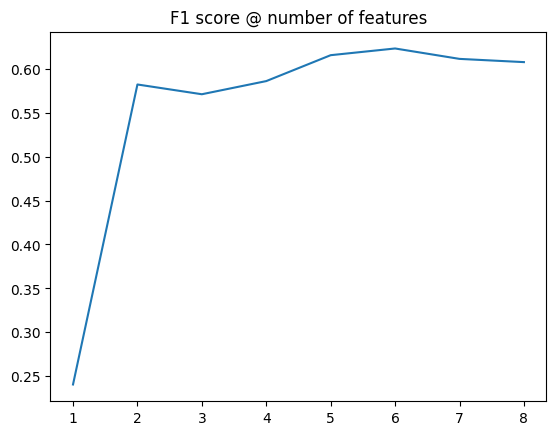

In [16]:
grid_output = pd.DataFrame.from_dict(grid.cv_results_, orient="columns")
plt.plot(range(1,X.shape[1]), grid_output.mean_test_score)
plt.title("F1 score @ number of features")

In [17]:
pipe = Pipeline([("selector", SelectKBest(chi2, k = 6)), ("classifier",model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["KBest_chi2"] = features.tolist()

<font size = 3><u> 3. KBest univariate feature selection (f_classif test) optimization

In [18]:
# Parameters optimization

pipe = Pipeline([
    ("selector", SelectKBest(f_classif)), ("classifier",model)
])

parameters = {"selector__k": range(1, X.shape[1])}

grid = GridSearchCV(pipe, parameters, cv=cv, scoring="f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)

{'selector__k': 2}
Pipeline(steps=[('selector', SelectKBest(k=2)),
                ('classifier', QuadraticDiscriminantAnalysis())])


Text(0.5, 1.0, 'F1 score @ number of features')

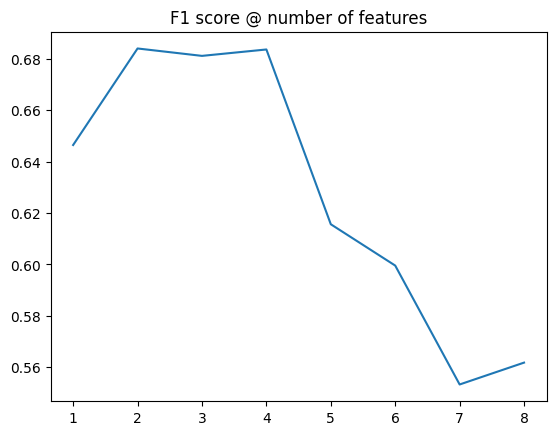

In [19]:
grid_output = pd.DataFrame.from_dict(grid.cv_results_, orient="columns")
plt.plot(range(1,X.shape[1]), grid_output.mean_test_score)
plt.title("F1 score @ number of features")

In [20]:
pipe = Pipeline([("selector", SelectKBest(f_classif, k = 2)), ("classifier",model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["KBest_ftest"] = features.tolist()

<font size = 3><u> 4. Sequential Feature Selector optimization  
\>> forward

In [21]:
pipe = Pipeline([("selector", SequentialFeatureSelector(model, n_features_to_select = "auto", direction = "forward")), ("classifier", model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["forward_select"] = features.tolist()

<font size = 3><u> 4. Sequential Feature Selector optimization  
\>> backward

In [22]:
pipe = Pipeline([("selector", SequentialFeatureSelector(model, n_features_to_select = "auto", direction = "backward")), ("classifier", model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["backward_select"] = features.tolist()

<font size = 3><u> Best subset classification according to F1 score

In [23]:
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
model = QuadraticDiscriminantAnalysis()

pipe = Pipeline([("classifier", model)])

f1_scores = {}
for key in feature_selection.keys():
    columns = feature_selection[key]
    x = X[columns]
    scores = cross_val_score(pipe, x, y, cv=cv, scoring = "f1", n_jobs=-1)
    score = np.mean(scores)
    f1_scores[key] = score

sorted(f1_scores.items(), key = lambda item: item[1], reverse = True)

[('forward_select', 0.6859761579464198),
 ('backward_select', 0.6839322786590099),
 ('KBest_ftest', 0.6829717970538455),
 ('VarianceThreshold', 0.6255594265937183),
 ('KBest_chi2', 0.6255594265937183),
 ('Features_set', 0.5429062228736142)]

Best F1 score is achieved with forward SFS (sequential feature selection)

<font size = 3><u> Put it all together: rank features according to their presence in different filtering methods

In [24]:
features_df = pd.DataFrame({"Feature": feature_selection["Features_set"]})

filter_methods = list(feature_selection.keys())[1:]

for filter in filter_methods:
    features_df.loc[:, filter] = False
    features_df.loc[features_df["Feature"].isin(feature_selection[filter]),filter] = True

features_df["COUNT"] = features_df.iloc[:,1:].sum(axis = 1) # add COUNT column
features_df.sort_values(by=["COUNT"], ascending = False, inplace = True) # sort by COUNT column in descending order
features_df = features_df.reset_index(drop=True)
features_df

,Feature,VarianceThreshold,KBest_chi2,KBest_ftest,forward_select,backward_select,COUNT
0,momentum30,True,True,True,True,True,5
1,momentum60,True,True,True,True,True,5
2,vs_quantile_binary_freq,True,True,False,True,True,4
3,divergence,True,True,False,False,True,3
4,daily_returns,False,False,False,True,True,2
5,momentum120,True,True,False,False,False,2
6,vs_quantile_binary,True,True,False,False,False,2
7,vs_quantile,False,False,False,False,False,0
8,lag_returns,False,False,False,False,False,0


In [25]:
# According to F1 score SFS forward is superior.
# Can the result be improved with subset >3? 

features1 = features_df.loc[features_df.COUNT >= 3,"Feature"].tolist()
features1

x = X[features1]

scores = cross_val_score(pipe, x, y, cv=cv, scoring = "f1", n_jobs=-1)
score = np.mean(scores)
print("Score for feature1 subset: %.3f" % score)

Score for feature1 subset: 0.699


In [26]:
# Can the result be improved with subset >2?

features2 = features_df.loc[features_df.COUNT >= 2,"Feature"].tolist()
features2

x = X[features2]

scores = cross_val_score(pipe, x, y, cv=cv, scoring = "f1", n_jobs=-1)
score = np.mean(scores)
print("Score for feature2 subset: %.3f" % score)

Score for feature2 subset: 0.601


In [27]:
# Feature1 subset outperformed SFS forward  subset. Hence, continue with first. 

<b> Model Diagnostics </b>

In [28]:
# Extract feature names - ultimate set

features = features1

In [30]:
# Set X and y variables for QDA 

y = df.loc[:,"sell_signal"]
X = df.loc[:, features]

In [31]:
# Fit QDA using subset of variables

model = QuadraticDiscriminantAnalysis()
res = model.fit(X,y)

In [32]:
# Predict using specified model, assuming default threshold of 0.5

predict = res.predict_proba(X)
predict_proba = res.predict_proba(X)[:, 1]
predict_class = [True if x > 0.5 else False for x in predict_proba]

In [33]:
# Model diagnostics on 10-fold stratified data

pipe = Pipeline([("classifier", model)])

ys = []
probabilities = []
classes = []

for train, test in cv.split(X,y):
    X_train, X_test = X.loc[train,:], X.loc[test,:]
    y_train, y_test = y[train], y[test]

    pipe.fit(X_train,y_train)
    probability_test = pipe.predict_proba(X_test)[:,1]
    class_test = [True if x > 0.5 else False for x in probability_test]

    ys += y_test.tolist()
    probabilities += probability_test.tolist()
    classes += class_test

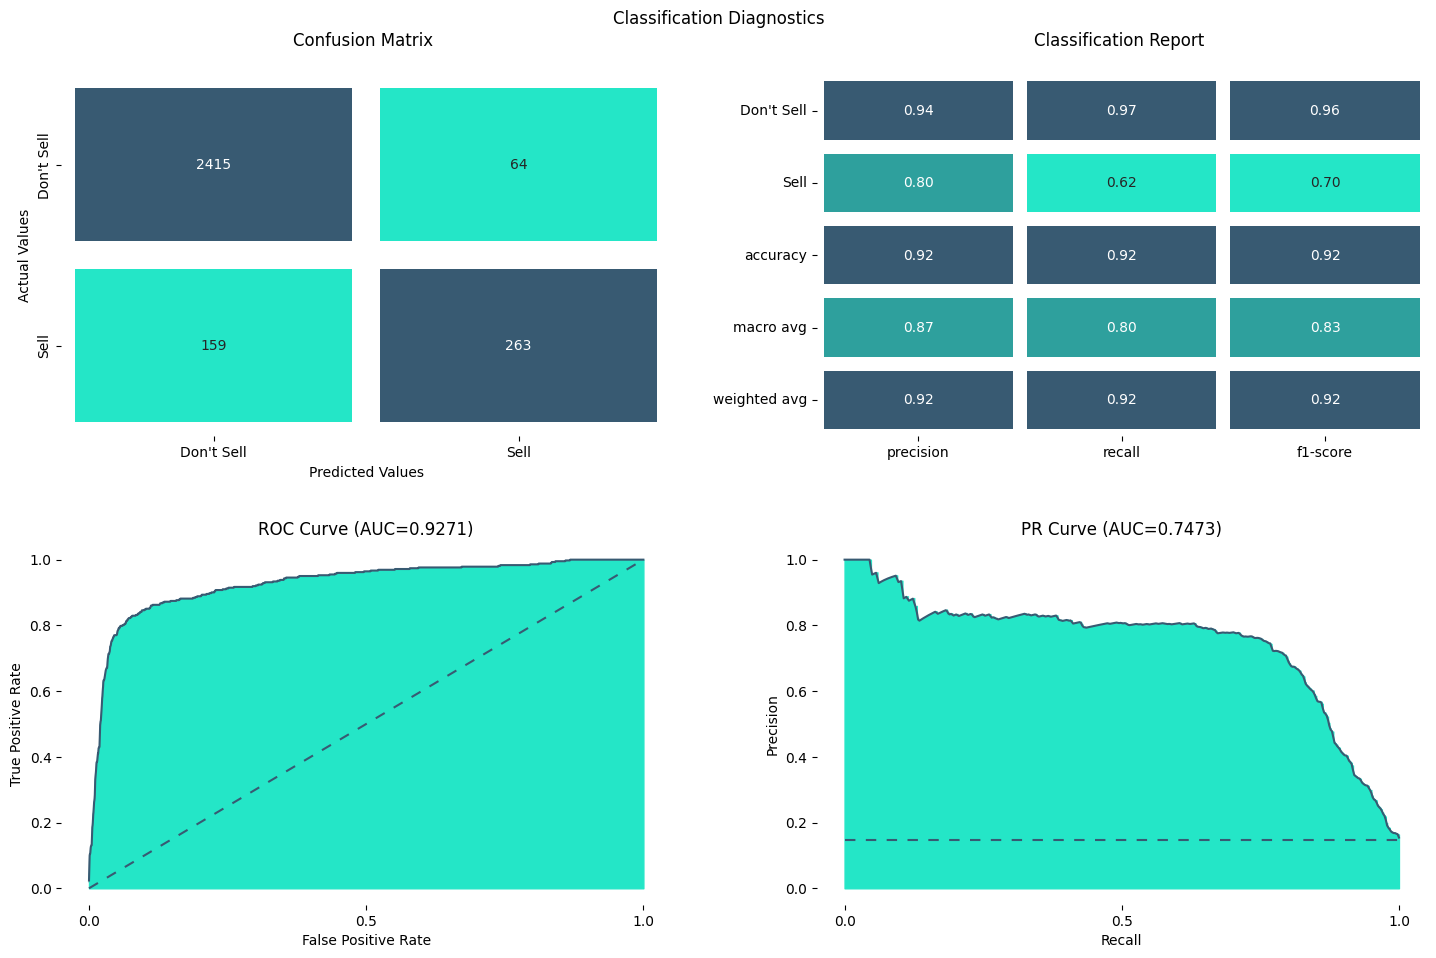

In [34]:
# Perform model CV diagnostics 

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

In [39]:
# Finding optimal threshold for ROC curve - G-Mean

fpr, tpr, thresholds = roc_curve(ys, probabilities)

gmeans = np.sqrt(tpr * (1 - fpr))
idx = np.argmax(gmeans)
print("Best threshold = %f, G-Mean = %.3f" % (thresholds[idx], gmeans[idx]))

Best threshold = 0.122161, G-Mean = 0.875


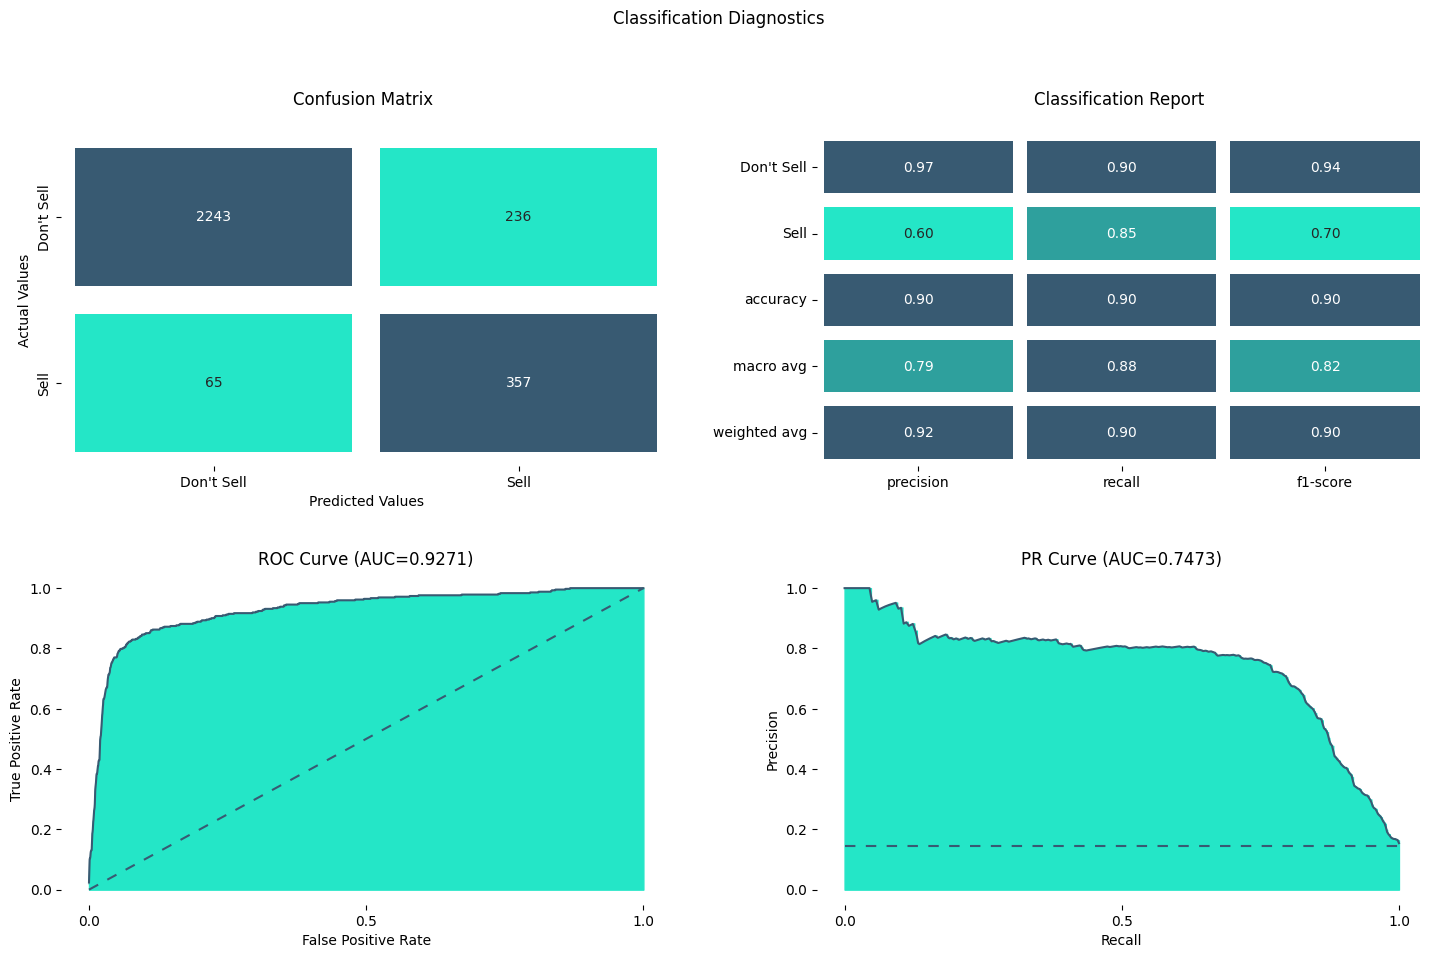

In [40]:
# G-Mean outputs threshold of = 0.122161. For this value, let's reprint diagnostics

threshold = thresholds[idx]
classes = [True if x >= threshold else False for x in probabilities]

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

In [41]:
# Finding optimal threshold for ROC curve - Youden's J statistic

fpr, tpr, thresholds = roc_curve(ys, probabilities)

J = tpr - fpr
idx = np.argmax(J)
print("Best threshold = %f, J = %.3f" % (thresholds[idx], J[idx]))

Best threshold = 0.150338, J = 0.752


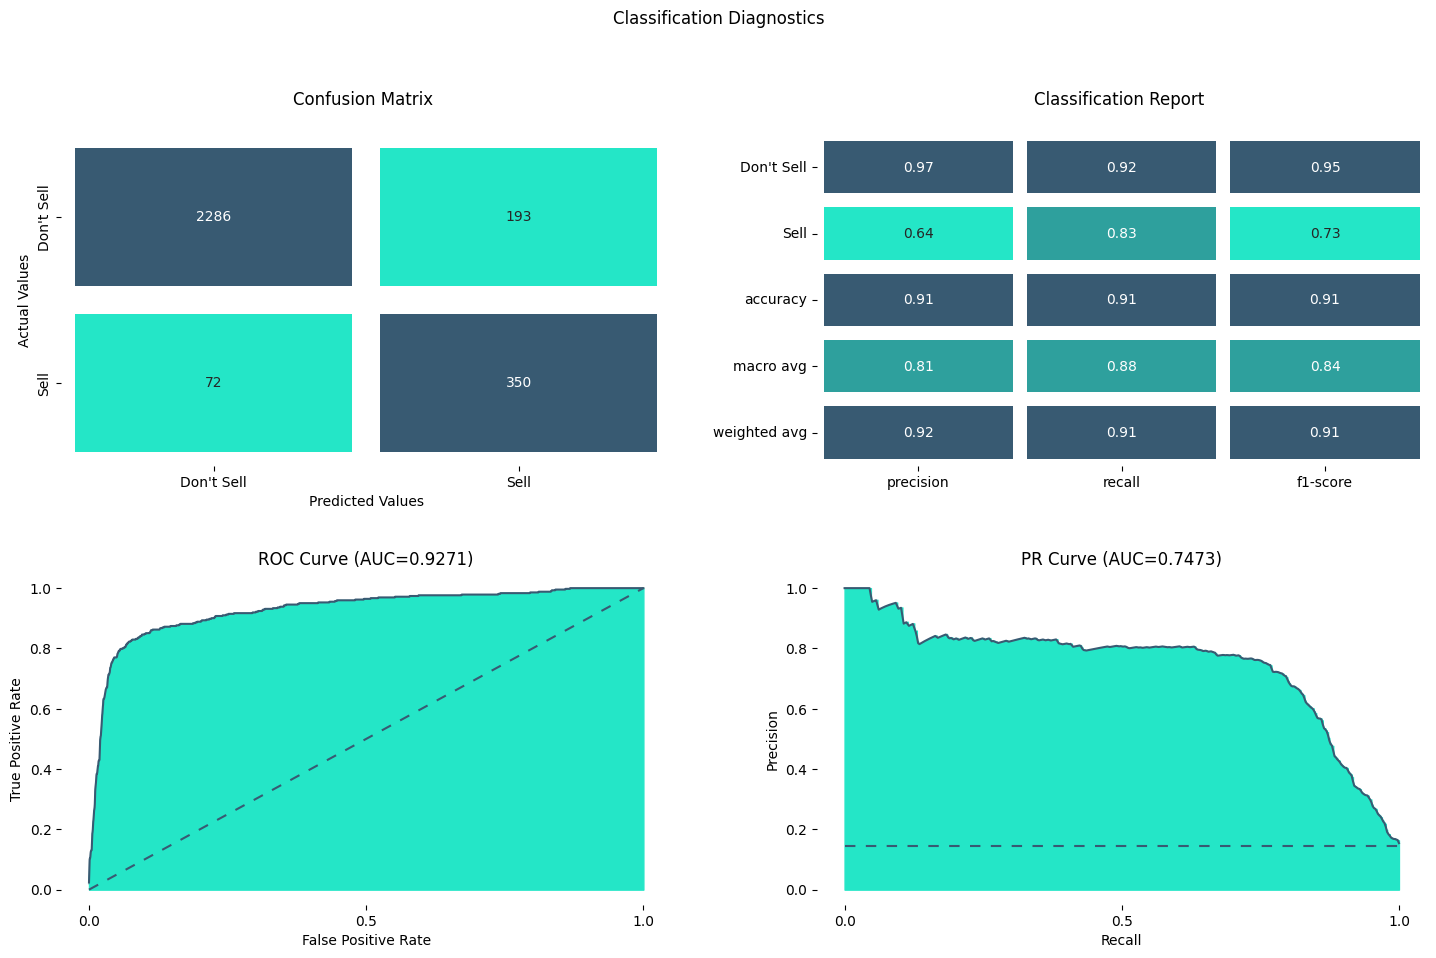

In [42]:
# J-stat outputs threshold of = 0.150338. For this value, let's reprint diagnostics

threshold = thresholds[idx]
classes = [True if x >= threshold else False for x in probabilities]

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

In [43]:
# Finding optimal threshold for PR curve - F-Measure

precision, recall, thresholds = precision_recall_curve(ys, probabilities)

fscore = (2 * precision * recall) / (precision + recall)
idx = np.argmax(fscore)
print("Best threshold = %f, F-Score = %.3f" % (thresholds[idx], fscore[idx]))

Best threshold = 0.288427, F-Score = 0.757


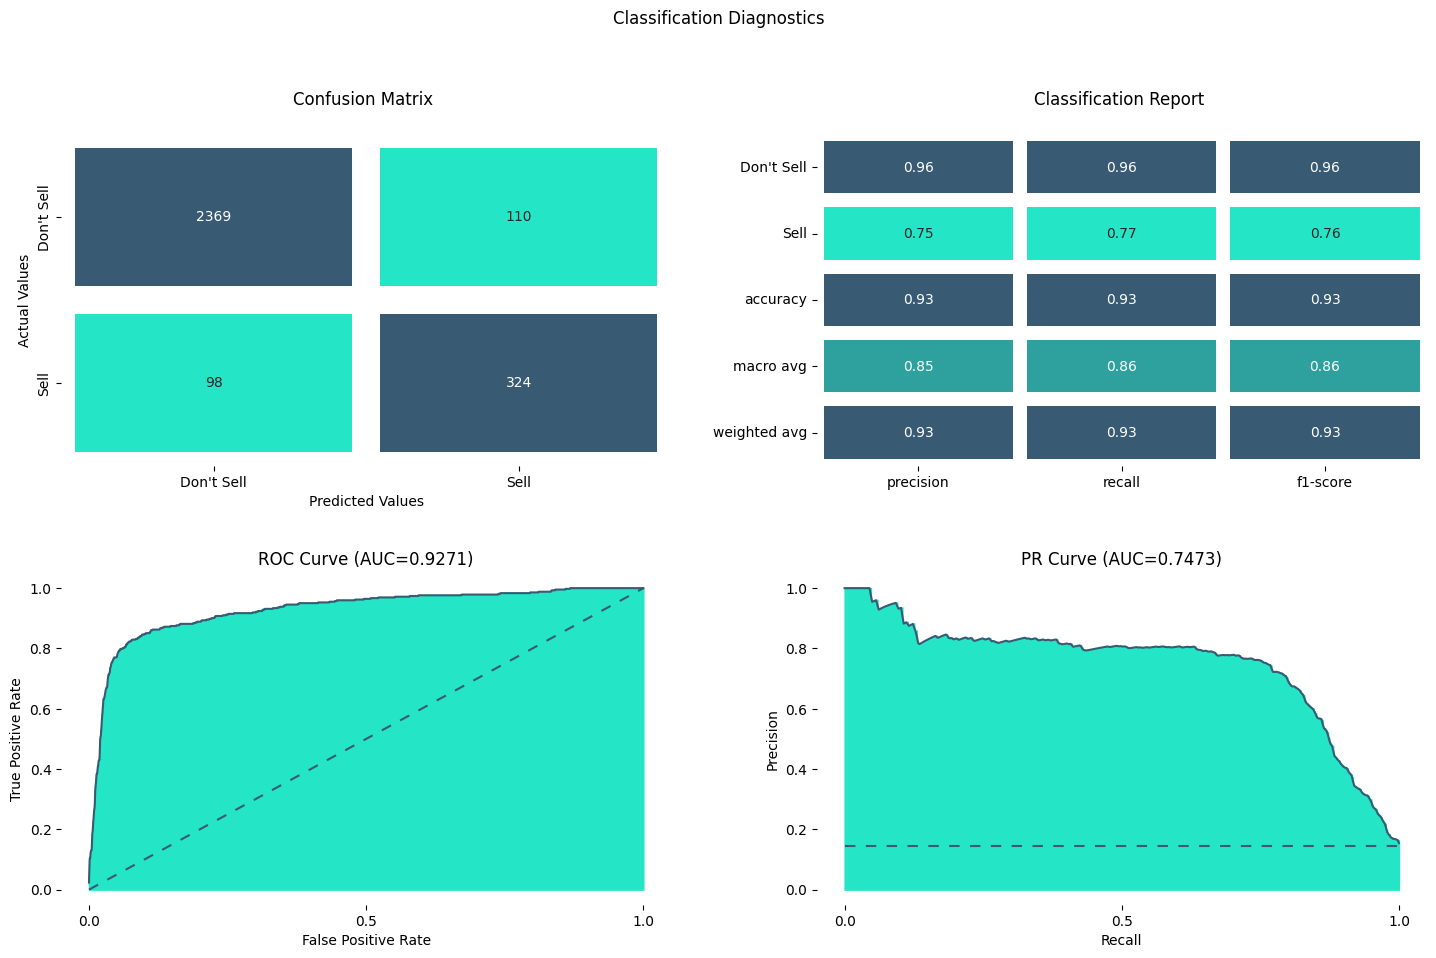

In [44]:
# FMeasure outputs threshold of = 0.288427. For this value, let's reprint diagnostics

threshold = thresholds[idx]
classes = [True if x >= threshold else False for x in probabilities]

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

<b> WORKINGS